In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as plot
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

pd.options.display.max_columns = 50
pd.options.display.max_rows = 80

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train = '/content/drive/My Drive/WORK_bank_data_train.csv'
test = '/content/drive/My Drive/WORK_WORK_BANK_DATA_test_sample.csv'

#загрузим тестовые и трейновые данные
df_train = pd.read_csv(train, sep=';')
df_test = pd.read_csv(test, sep=';')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Сервис

In [ ]:
'''
В этой строчке кода содержатся гиперпараметры (бюджет компании), которые задаются пользователем
'''

#бюджет компании
budget = 100000

#стоимость коммуникации
cost_email = 5
cost_sms = 25

#конверсия
conversion_email = 0.1
conversion_sms = 0.2

#ограничения по коммуникации (в %)
max_email = 0.7
max_sms = 0.3

In [ ]:
#загрузим тестовые и трейновые данные
#df_train = pd.read_csv('WORK_bank_data_train.csv', sep=';')
#df_test = pd.read_csv('WORK_WORK_BANK_DATA_test_sample.csv', sep=';') #файл может быть изменен пользователем

#ценность клиента, рассчитываемая по переменной trans_3_month - транзакции за последние три месяца
#(сохраним только для тестовой выборки)
client_importance = df_test.trans_3_month / df_train.trans_3_month.max()

In [ ]:
'''
Функция, которая принимает на вход датафрейм, обрабатывает его и выдает данные, готовые для построения моделей
'''

def data_preparation(df, is_train=True):
    
    def encoder(data, columns):
        for column in columns:
            tmp = pd.get_dummies(data[column], prefix=column)
            data = data.drop(columns=[column])
            data = data.join(tmp)
        return data
    
    def code(data, columns):
        for column in columns:
            data[column] = 1 * (data[column] == 'Yes')
        return data

    df['Age'].fillna(round(df['Age'].mean(), 0), inplace=True)
    df['Lifetime'].fillna(round(df['Lifetime'].mean(), 0), inplace=True)
    
    if not is_train:
        df.rename(columns = {'Ind_House_hold' : 'Ind_Household'}, inplace = True)
    
    columns_to_delete_train = ['Ind_email', 'Ind_phone']

    columns_to_delete = ["Ind_Household", "District", "Ind_deposit", "Ind_salary",
                      "trans_6_month", "trans_9_month", "trans_12_month", "amont_trans",
                      "trans_3_month"] #IV < 0.01

    if is_train:
        columns_to_label_encoding = ['Target1', 'Target2']
        df = code(df, columns=columns_to_label_encoding)
        df.drop(columns=columns_to_delete_train, inplace=True)

    df.drop(columns=columns_to_delete, inplace=True)
    
    columns_to_encoder = ['Age_group', 'Region', 'Segment', 'Gender']
    df = encoder(df, columns=columns_to_encoder)

    df.drop(columns=["Region_Unknown", "Gender_U", "Age_group_unknown"], inplace=True)
    
    return df

In [ ]:
#обработка данных
df_train = data_preparation(df_train)
df_test = data_preparation(df_test, False)

#делим данные на регрессоры и два таргета
y1 = df_train.loc[:, ['Target1']] #колонка таргета 1
y2 = df_train.loc[:, ['Target2']] #колонка таргета 2
x = df_train.drop(columns = ['Target1', 'Target2']) #фичи

#лучшая модель для таргета 1 (e-mail)
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb_best_for_email = XGBClassifier(
        learning_rate=0.1,     
        n_estimators=150,   
        max_depth=10,
        min_child_weight=4,
        gamma=0.4,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.1,
        objective='binary:logistic',  
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb_best_for_email.fit(x, y1.values)

df_test['prob_email'] = xgb_best_for_email.predict_proba(df_test)[:, 1]

#лучшая модель для таргета 2 (sms)

xgb_best_for_sms = XGBClassifier(
        learning_rate=0.1,     
        n_estimators=150,   
        max_depth=15,
        min_child_weight=1,
        gamma=0.9,
        subsample=0.9,
        colsample_bytree=0.6,
        reg_alpha=0.01,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb_best_for_sms.fit(x, y2.values)

df_test['prob_sms'] = xgb_best_for_sms.predict_proba(df_test.drop(columns=['prob_email']))[:, 1]

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
'''
Алгоритм для определения вероятностей отклика на коммуникацию с учетом ценности клиента и конверсии
'''

def client_probabilities(df):

    #добавим вероятности отклика на каждую коммуникацю в таблицу и добавим столбец ценности каждого клиента
    df['client_importance'] = client_importance

    #преобразуем вероятности отклика на каждую коммуникацию с учетом конверсии и ценности клиента
    df['prob_email_imp_conv'] = df['prob_email'] * df['client_importance'] * conversion_email
    df['prob_sms_imp_conv'] = df['prob_sms'] * df['client_importance'] * conversion_sms

    #выберем колонку с наибольшей вероятностью для каждого клиента (и создадим еще одну переменную, которая будет означать,
    #какая коммуникация для этого клиента подходит (email, sms))
    df['communication'] = 'None'
    for i in range(0, len(df)):
      if df.iloc[i]['prob_email_imp_conv'] >= df.iloc[i]['prob_sms_imp_conv']:
        df.at[i, 'communication'] = 'email'
      else:
        df.at[i, 'communication'] = 'sms'
  
    #создадим колонку с общими вероятностями для сортировки клиентом (выбираем отклик, на который клиент вероятнее всего откликнется)
    df['probs_for_sort'] = df[['prob_email_imp_conv', 'prob_sms_imp_conv']].max(axis = 1)

    #отсортируем клиентов по вероятности отклика
    df = df.sort_values(by=['probs_for_sort'], ascending=False)
    df = df.reset_index(drop=True)

    return df

In [ ]:
''' 
Формирование предложения по коммуникации для клиентов
'''

df_test = client_probabilities(df_test)

#посчитаем, сколько sms и email мы можем отправить, исходя из наших ограничений
num_email = budget * max_email / cost_email
num_sms = budget * max_sms / cost_sms

results = pd.DataFrame(columns=['ID', 'communication_type'])

#функция, которая при заданных ограничениях выбирает клиентов для коммуникации и тип коммуникации для каждого клиента
n_email = 0
n_sms = 0
clients_for_email = []
clients_for_sms = []
type_email = []
type_sms = []
for i in range(0, len(df_test)):
  if n_email == num_email:
    break 
  if df_test.iloc[i]['communication'] == 'email':
    clients_for_email.append(df_test.iloc[i]['ID']) 
    type_email.append(df_test.iloc[i]['communication'])
    n_email += 1
for i in range(0, len(df_test)):
  if n_sms == num_sms:
    break 
  if df_test.iloc[i]['communication'] == 'sms':
    clients_for_sms.append(df_test.iloc[i]['ID'])
    type_sms.append(df_test.iloc[i]['communication'])  
    n_sms += 1

ids = clients_for_email + clients_for_sms
communication_type = type_email + type_sms

results = pd.DataFrame({'ID': ids, 'communication_type': communication_type}) 
pd.options.display.max_rows = 1000
results

,ID,communication_type
0,1200601059,email
1,1200798267,email
2,1201029241,email
3,1200559945,email
4,1200612553,email
...,...,...
15195,1200712630,sms
15196,1201044353,sms
15197,1200570780,sms
15198,1200086300,sms


####Финансовое обоснование.

In [ ]:
df_train1 = pd.read_csv(train, sep=';')
df_test1 = pd.read_csv(test, sep=';')

In [ ]:
#df_train1 = pd.read_csv('WORK_bank_data_train.csv', sep=';')
#df_test1 = pd.read_csv('WORK_WORK_BANK_DATA_test_sample.csv', sep=';')

In [ ]:
df_train1

,ID,Age,Ind_Household,Age_group,District,Region,Lifetime,Income,Segment,Ind_deposit,Ind_email,Ind_phone,Ind_salary,trans_6_month,trans_9_month,trans_12_month,amont_trans,amont_day_from,trans_3_month,Gender,Target1,Target2
0,1200000001,51.0,No,middle,02,Midlands,3.0,53,Platinum,No,Yes,Yes,No,2026.27,2964.23,4140.91,3,21,910.02,F,No,No
1,1200000002,47.0,No,middle,34,Midlands,2.0,51,Gold,No,Yes,Yes,No,2033.14,2969.30,4202.63,5,14,977.80,U,No,No
2,1200000003,45.0,No,middle,17,North,6.0,50,Silver,No,Yes,Yes,No,2085.68,3080.13,4277.45,11,16,1001.54,M,No,No
3,1200000004,78.0,No,senior,49,Midlands,12.0,52,Platinum,Yes,Yes,Yes,No,2026.58,3001.34,4105.54,3,15,980.78,F,No,No
4,1200000005,57.0,No,middle,19,South East,8.0,52,Silver,Yes,Yes,Yes,No,2142.23,3188.19,4401.98,2,26,1003.68,F,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985472,1201048571,NaN,No,unknown,12,South East,6.0,42,Silver,Yes,Yes,Yes,No,2139.03,3155.41,4291.97,10,14,989.90,F,No,No
985473,1201048572,63.0,No,senior,33,South East,9.0,51,Tin,No,Yes,Yes,No,1916.91,3000.02,4045.15,11,30,884.63,F,No,No
985474,1201048573,68.0,No,senior,51,North,3.0,56,Gold,Yes,Yes,Yes,No,2053.00,3112.87,4292.20,8,16,922.66,M,No,No
985475,1201048574,45.0,No,middle,45,Midlands,1.0,54,Gold,Yes,Yes,Yes,No,2082.85,3143.77,4207.48,8,15,951.42,M,No,No


Предположим, что каждый клиент совершит в следующем месяце столько транзакций, сколько в среднем в месяц он совершил за последние 3 месяца - это будет новая переменная, которую мы хотим научиться предсказывать (в этот раз используем линейную регрессию).

In [ ]:
df_train1['trans_future_month'] = df_train1['trans_3_month'] / 3

In [ ]:
df_train1

,ID,Age,Ind_Household,Age_group,District,Region,Lifetime,Income,Segment,Ind_deposit,Ind_email,Ind_phone,Ind_salary,trans_6_month,trans_9_month,trans_12_month,amont_trans,amont_day_from,trans_3_month,Gender,Target1,Target2,trans_future_month
0,1200000001,51.0,No,middle,02,Midlands,3.0,53,Platinum,No,Yes,Yes,No,2026.27,2964.23,4140.91,3,21,910.02,F,No,No,303.340000
1,1200000002,47.0,No,middle,34,Midlands,2.0,51,Gold,No,Yes,Yes,No,2033.14,2969.30,4202.63,5,14,977.80,U,No,No,325.933333
2,1200000003,45.0,No,middle,17,North,6.0,50,Silver,No,Yes,Yes,No,2085.68,3080.13,4277.45,11,16,1001.54,M,No,No,333.846667
3,1200000004,78.0,No,senior,49,Midlands,12.0,52,Platinum,Yes,Yes,Yes,No,2026.58,3001.34,4105.54,3,15,980.78,F,No,No,326.926667
4,1200000005,57.0,No,middle,19,South East,8.0,52,Silver,Yes,Yes,Yes,No,2142.23,3188.19,4401.98,2,26,1003.68,F,Yes,No,334.560000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985472,1201048571,NaN,No,unknown,12,South East,6.0,42,Silver,Yes,Yes,Yes,No,2139.03,3155.41,4291.97,10,14,989.90,F,No,No,329.966667
985473,1201048572,63.0,No,senior,33,South East,9.0,51,Tin,No,Yes,Yes,No,1916.91,3000.02,4045.15,11,30,884.63,F,No,No,294.876667
985474,1201048573,68.0,No,senior,51,North,3.0,56,Gold,Yes,Yes,Yes,No,2053.00,3112.87,4292.20,8,16,922.66,M,No,No,307.553333
985475,1201048574,45.0,No,middle,45,Midlands,1.0,54,Gold,Yes,Yes,Yes,No,2082.85,3143.77,4207.48,8,15,951.42,M,No,No,317.140000


Проведем простую предобрабатку данных (часть будем использовать уже исходя из предыдущего анализа).

In [ ]:
def data_preparation1(df, is_train=True):

    def code(data, columns):
      for column in columns:
          data[column] = 1 * (data[column] == 'Yes')
      return data

    def encoder(data, columns):
      for column in columns:
          tmp = pd.get_dummies(data[column], prefix=column)
          data = data.drop(columns=[column])
          data = data.join(tmp)
      return data

    df['Age'].fillna(round(df['Age'].mean(), 0), inplace=True)
    df['Lifetime'].fillna(round(df['Lifetime'].mean(), 0), inplace=True)
    
    if not is_train:
        df.rename(columns = {'Ind_House_hold' : 'Ind_Household'}, inplace = True)

    columns_to_code = ['Ind_Household', 'Ind_deposit', 'Ind_salary']
    
    columns_to_delete_train = ['Ind_email', 'Ind_phone', 'Target1', 'Target2']

    if is_train:
        df.drop(columns=columns_to_delete_train, inplace=True)

    df = code(df, columns=columns_to_code)

    columns_to_encoder = ['Age_group', 'Region', 'Segment', 'Gender']
    df = encoder(df, columns=columns_to_encoder)
    
    df.drop(columns=["Region_Unknown", "Gender_U", "Age_group_unknown"], inplace=True)
    
    return df

In [ ]:
df_train1 = data_preparation1(df_train1)
df_test1 = data_preparation1(df_test1, False)

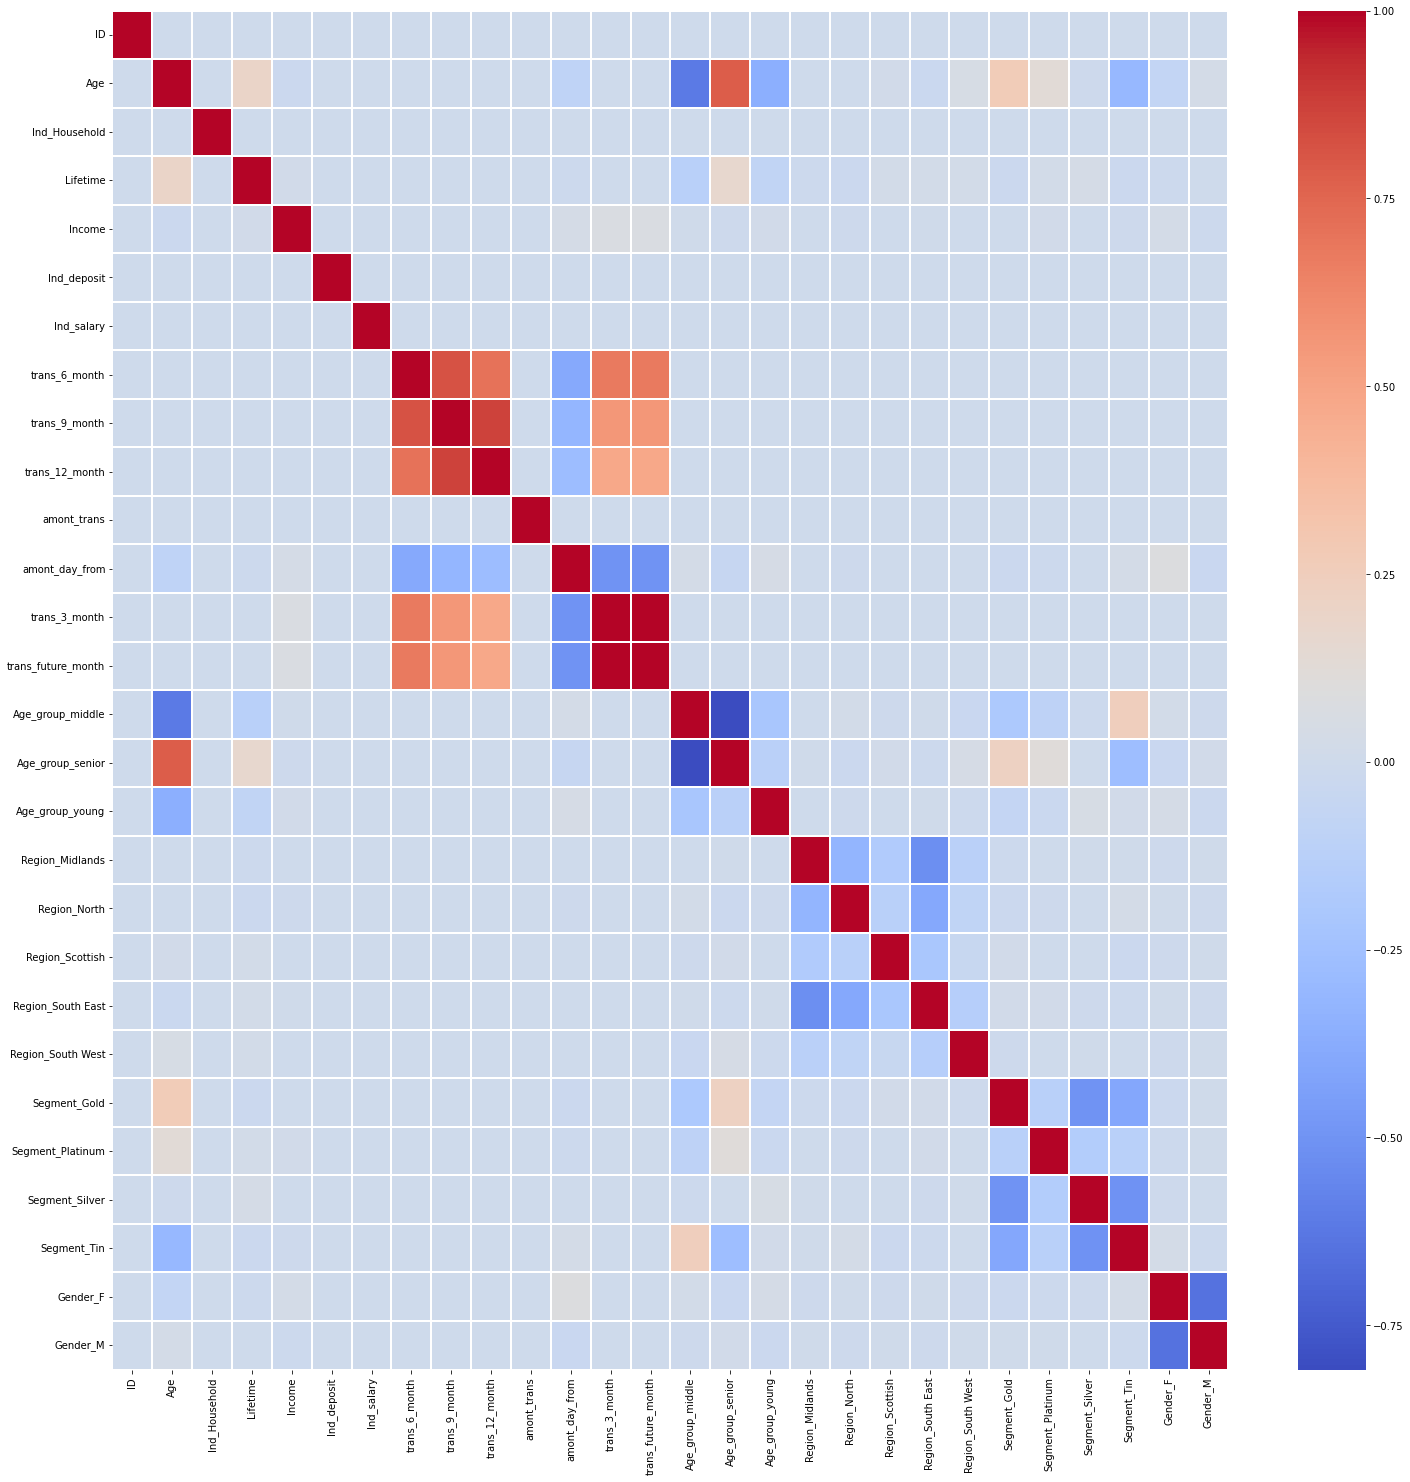

In [ ]:
#построим корреляционную матрицу, чтобы определить, по каким переменным мы будем строить прогнозы
#для предсказания будущей суммы транзакций за месяц
import seaborn as sns
corr_matrix = df_train1.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr_matrix, cmap = 'coolwarm',  linewidths=1, linecolor='white')

Ожидаемо наибольшую корреляцию имеют суммы транзакций за последние 3, 6, 9, 12 месяцев и количество дней, сколько клиент не пользовался услугами. Однако мы не можем строить предсказания только по этой информации, поэтому добавим осмысленно в модель другие переменные.

Вероятнее всего на сумму транзакций будут влиять Income, Age, Region, Lifetime (время с банком), Segment (статус клиента), Ind_deposit (наличие депозита), Ind_salary (наличие зарплатной карты), amont_trans, естесственно, транзакции за предыдущие месяца (возьмем только шесть, так как если возьмем за 3 месяца, модель все остальное будет игнорировать), amont_day_from (дни с последней транзакции) и Gender (пол).

In [ ]:
df_train1.columns

Index(['ID', 'Age', 'Ind_Household', 'District', 'Lifetime', 'Income',
       'Ind_deposit', 'Ind_salary', 'trans_6_month', 'trans_9_month',
       'trans_12_month', 'amont_trans', 'amont_day_from', 'trans_3_month',
       'trans_future_month', 'Age_group_middle', 'Age_group_senior',
       'Age_group_young', 'Region_Midlands', 'Region_North', 'Region_Scottish',
       'Region_South East', 'Region_South West', 'Segment_Gold',
       'Segment_Platinum', 'Segment_Silver', 'Segment_Tin', 'Gender_F',
       'Gender_M'],
      dtype='object')

In [ ]:
model_vars = ['Age', 'Lifetime', 'Income', 'Ind_deposit', 'Ind_salary', 
              'trans_6_month', 'amont_trans', 'amont_day_from',
              'Region_Midlands', 'Region_North', 'Region_Scottish',
              'Region_South East', 'Region_South West', 'Segment_Gold',
              'Segment_Platinum', 'Segment_Silver', 'Segment_Tin', 'Gender_F',
              'Gender_M']

In [ ]:
df_train1[model_vars].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985477 entries, 0 to 985476
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                985477 non-null  float64
 1   Lifetime           985477 non-null  float64
 2   Income             985477 non-null  int64  
 3   Ind_deposit        985477 non-null  int64  
 4   Ind_salary         985477 non-null  int64  
 5   trans_6_month      985477 non-null  float64
 6   amont_trans        985477 non-null  int64  
 7   amont_day_from     985477 non-null  int64  
 8   Region_Midlands    985477 non-null  uint8  
 9   Region_North       985477 non-null  uint8  
 10  Region_Scottish    985477 non-null  uint8  
 11  Region_South East  985477 non-null  uint8  
 12  Region_South West  985477 non-null  uint8  
 13  Segment_Gold       985477 non-null  uint8  
 14  Segment_Platinum   985477 non-null  uint8  
 15  Segment_Silver     985477 non-null  uint8  
 16  Se

Построим простую линейную регрессию для предсказания транзакций на будущий месяц.

In [ ]:
#divide train dataset to check our future model
from sklearn.model_selection import train_test_split

np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(df_train1[model_vars], df_train1['trans_future_month'], test_size = 0.3)

In [ ]:
from sklearn.linear_model import LinearRegression

model_future_trans = LinearRegression()
model_future_trans.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred_train = model_future_trans.predict(X_train)
y_pred_test = model_future_trans.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error

print("MAE for train: ", mean_absolute_error(y_train, y_pred_train))
print("MAE for test: ", mean_absolute_error(y_test, y_pred_test))

MAE for train:  8.67510414912106
MAE for test:  8.686334396039891


In [ ]:
#коэффициенты регрессии
features = list(X_train.columns) 
for co, fe in zip(model_future_trans.coef_, features):
    print(fe, round(co, 2))

Age -0.03
Lifetime 0.01
Income 0.24
Ind_deposit 0.07
Ind_salary -0.08
trans_6_month 0.13
amont_trans -0.0
amont_day_from -0.65
Region_Midlands 0.09
Region_North -0.03
Region_Scottish -0.04
Region_South East 0.01
Region_South West 0.14
Segment_Gold 0.02
Segment_Platinum -0.04
Segment_Silver -0.01
Segment_Tin 0.04
Gender_F 0.79
Gender_M 0.23


Вышло неплохо. Теперь предскажем то же самое для тестовой выборки. Обучим модель на всей трейновой выборке и предскажем для теста.

In [ ]:
model_future_trans_final = LinearRegression()
model_future_trans_final.fit(df_train1[model_vars], df_train1['trans_future_month'])

LinearRegression()

In [ ]:
df_test1['future_trans_1_month'] = model_future_trans_final.predict(df_test1[model_vars])

In [ ]:
df_test1

,ID,Age,Ind_Household,District,Lifetime,Income,Ind_deposit,Ind_salary,trans_6_month,trans_9_month,trans_12_month,amont_trans,amont_day_from,trans_3_month,Age_group_middle,Age_group_senior,Age_group_young,Region_Midlands,Region_North,Region_Scottish,Region_South East,Region_South West,Segment_Gold,Segment_Platinum,Segment_Silver,Segment_Tin,Gender_F,Gender_M,future_trans_1_month
0,1200000027,50.0,0,22,5.0,47,1,0,2062.32,2978.92,4054.13,7,17,950.45,1,0,0,0,0,0,1,0,0,0,0,1,0,1,319.965088
1,1200000040,34.0,0,47,5.0,54,0,0,2000.73,3111.23,4265.02,5,17,982.29,1,0,0,0,0,0,1,0,0,0,0,1,1,0,314.679036
2,1200000041,54.0,1,14,28.0,52,1,0,1991.05,2990.26,4193.14,9,33,909.27,0,0,0,0,0,0,1,0,1,0,0,0,1,0,302.041939
3,1200000071,61.0,0,23,3.0,54,1,0,2094.12,3089.97,4167.11,5,17,933.91,0,1,0,1,0,0,0,0,0,0,1,0,1,0,326.023124
4,1200000080,44.0,0,51,8.0,43,1,0,2034.41,2972.27,4165.87,5,17,917.13,1,0,0,0,1,0,0,0,0,0,1,0,1,0,316.044352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63093,1201048525,67.0,1,45,1.0,48,1,0,2037.32,3084.48,4236.37,12,33,904.46,0,1,0,1,0,0,0,0,0,0,1,0,0,1,305.983163
63094,1201048529,75.0,0,14,9.0,46,1,0,2048.42,3072.78,4203.52,7,17,1026.79,0,1,0,1,0,0,0,0,0,0,0,1,1,0,317.785928
63095,1201048544,54.0,0,04,2.0,53,1,0,2120.81,3167.97,4343.64,16,17,1017.48,1,0,0,1,0,0,0,0,1,0,0,0,0,0,328.671602
63096,1201048557,41.0,1,27,13.0,44,1,0,2133.01,3201.82,4284.59,12,17,979.36,1,0,0,0,0,0,0,1,0,0,0,1,1,0,329.380951


Чтобы обосновать с финансовой точки зрения нашу кампанию, ранее мы вывели списки клиентов для конкретного бюджета, отклика и всего прочего. Теперь представим, что наша компания Х хочет увеличить количество транзакций в следующем месяце. 

Она формирует предложение:

"Потратьте в следующем месяце более Y рублей и получите 10% кэшбека со всех покупок"

Логичный вопрос: зачем мы предсказывали сумму транзакций? Чтобы понимать примерно, сколько наши клиенты собираются потратить. На этом этапе мы рассчитаем, сколько наша целевая группа (клиенты, которым мы делаем рассылку) собиралась потратить без нашего вмешательства. Потом мы рассчитаем Y - то есть, сколько денег компания предложит потратить клиентам (целевой группе) в следующем месяце, и сформируем предложение, и уже затем посчитаем финансовую целесообразность компании а, следовательно, и сервиса.

In [ ]:
df_test

,ID,Age,Lifetime,Income,amont_day_from,Age_group_middle,Age_group_senior,Age_group_young,Region_Midlands,Region_North,Region_Scottish,Region_South East,Region_South West,Segment_Gold,Segment_Platinum,Segment_Silver,Segment_Tin,Gender_F,Gender_M,prob_email,prob_sms,client_importance,prob_email_imp_conv,prob_sms_imp_conv,communication,probs_for_sort
0,1200238201,39.0,8.0,58,17,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0.960818,0.964270,0.974166,0.093600,1.878719e-01,sms,0.187872
1,1200822522,61.0,3.0,71,17,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0.998641,0.990102,0.937957,0.093668,1.857347e-01,sms,0.185735
2,1200435310,39.0,11.0,65,17,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0.990705,0.986174,0.936560,0.092786,1.847222e-01,sms,0.184722
3,1200857017,54.0,7.0,75,17,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0.998509,0.991863,0.930172,0.092879,1.845206e-01,sms,0.184521
4,1200346130,38.0,8.0,54,17,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0.960766,0.968915,0.948596,0.091138,1.838218e-01,sms,0.183822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63093,1200918275,79.0,17.0,41,33,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0.001569,0.000030,0.743439,0.000117,4.417850e-06,email,0.000117
63094,1200183778,45.0,11.0,53,33,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0.001339,0.000006,0.747570,0.000100,9.647156e-07,email,0.000100
63095,1200219390,61.0,25.0,45,33,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0.001198,0.000022,0.777953,0.000093,3.368665e-06,email,0.000093
63096,1200297785,68.0,25.0,49,33,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0.001169,0.000026,0.742460,0.000087,3.932226e-06,email,0.000087


In [1]:
#присоединим колонку с предсказанной суммой транзакций к изначальному тестовому датасету с вероятностями
df_test = df_test.merge(df_test1['future_trans_1_month'], how='left', on=df_test['ID'])

NameError: ignored

In [ ]:
df_test.columns

Index(['key_0', 'ID', 'Age', 'Lifetime', 'Income', 'amont_day_from',
       'Age_group_middle', 'Age_group_senior', 'Age_group_young',
       'Region_Midlands', 'Region_North', 'Region_Scottish',
       'Region_South East', 'Region_South West', 'Segment_Gold',
       'Segment_Platinum', 'Segment_Silver', 'Segment_Tin', 'Gender_F',
       'Gender_M', 'prob_email', 'prob_sms', 'client_importance',
       'prob_email_imp_conv', 'prob_sms_imp_conv', 'communication',
       'probs_for_sort', 'future_trans_1_month'],
      dtype='object')

In [ ]:
''' 
Формирование предложения по коммуникации для клиентов
'''

results1 = pd.DataFrame(columns=['ID', 'communication_type'])

#функция, которая при заданных ограничениях выбирает клиентов для коммуникации и тип коммуникации для каждого клиента
n_email = 0
n_sms = 0
clients_for_email = []
clients_for_sms = []
type_email = []
type_sms = []
trans1 = []
prob_responce = []
for i in range(0, len(df_test)):
  if n_email == num_email:
    break 
  if df_test.iloc[i]['communication'] == 'email':
    clients_for_email.append(df_test.iloc[i]['ID']) 
    type_email.append(df_test.iloc[i]['communication'])
    trans1.append(df_test.iloc[i]['future_trans_1_month'])
    prob_responce.append(df_test.iloc[i]['prob_email']*conversion_email)
    n_email += 1
for i in range(0, len(df_test)):
  if n_sms == num_sms:
    break 
  if df_test.iloc[i]['communication'] == 'sms':
    clients_for_sms.append(df_test.iloc[i]['ID'])
    type_sms.append(df_test.iloc[i]['communication']) 
    trans1.append(df_test.iloc[i]['future_trans_1_month']) 
    prob_responce.append(df_test.iloc[i]['prob_sms']*conversion_sms)
    n_sms += 1

ids = clients_for_email + clients_for_sms
communication_type = type_email + type_sms

results1 = pd.DataFrame({'ID': ids, 'communication_type': communication_type, 'future_trans' : trans1, 'prob_responce' : prob_responce}) 
pd.options.display.max_rows = 1000
results1

,ID,communication_type,future_trans,prob_responce
0,1200601059,email,321.637476,0.099839
1,1200798267,email,313.219844,0.099288
2,1201029241,email,304.361375,0.098503
3,1200559945,email,306.700287,0.099930
4,1200612553,email,326.172755,0.099895
...,...,...,...,...
15195,1200712630,sms,306.247724,0.198458
15196,1201044353,sms,318.915521,0.194849
15197,1200570780,sms,297.321667,0.191023
15198,1200086300,sms,318.729100,0.172285


In [ ]:
results1.future_trans.sum() #сколько денег нам бы принесли они, если бы ничего не делали

4816099.928049462

In [ ]:
results1.prob_responce.sum() #учитывая вероятности, сколько человек к нам придет по предложению 
#также предположим, что остальные будут совершать транзакции как и раньше

716.8095607332885

Теперь посчитаем среднюю сумму транзакций всех клиентов целевой группы, чтобы понять, какое делать предложение.

In [ ]:
results1.future_trans.mean()

316.8486794769387

Увеличим среднюю сумму транзакций на 20%

In [ ]:
results1.future_trans.mean() * 1.2

380.21841537232643

Таким образом, предложение компании будем следующим (предложение для рассылки).

"Потратьте в следующем месяце более 380 тыс. рублей и получите 10% кэшбека со всех покупок"

Остальные расчеты представлены в таблице в эксель.